<img src="images/dask_horizontal.svg" align="right" width="30%">

# Arrays

<img src="images/array.png" width="25%" align="right">
Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

**Related Documentation**

* [Documentation](http://dask.readthedocs.io/en/latest/array.html)
* [API reference](http://dask.readthedocs.io/en/latest/array-api.html)

## Blocked Algorithms

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

For example, consider taking the sum of a billion numbers.  We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums.

We achieve the intended result (one sum on one billion numbers) by performing many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers.)

We do exactly this with Python and NumPy in the following example:

**Create random dataset**

In [2]:
# create data if it doesn't already exist
from prep import random_array
random_array()  

# Load data with h5py
# this creates a pointer to the data, but does not actually load
import h5py
import os
f = h5py.File(os.path.join('data', 'random.hdf5'), mode='r')
dset = f['/x']

**Compute sum using blocked algorithm**

Before using dask, lets consider the concept of blocked algorithms. We can compute the sum of a large number of elements by loading them chunk-by-chunk, and keeping a running total.

Here we compute the sum of this large array on disk by 

1.  Computing the sum of each 1,000,000 sized chunk of the array
2.  Computing the sum of the 1,000 intermediate sums

Note that this is a sequential process in the notebook kernel, both the loading and summing.

In [7]:
%%time
# Compute sum of large array, one million numbers at a time
sums = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

1000009898.0
CPU times: user 410 ms, sys: 380 ms, total: 790 ms
Wall time: 786 ms


### Exercise:  Compute the mean using a blocked algorithm

Now that we've seen the simple example above try doing a slightly more complicated problem, compute the mean of the array, assuming for a moment that we don't happen to already know how many elements are in the data.  You can do this by changing the code above with the following alterations:

1.  Compute the sum of each block
2.  Compute the length of each block
3.  Compute the sum of the 1,000 intermediate sums and the sum of the 1,000 intermediate lengths and divide one by the other

This approach is overkill for our case but does nicely generalize if we don't know the size of the array or individual blocks beforehand.

In [8]:
%%time
# Compute mean of large array, one million numbers at a time
sums = []
lens = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # pull out numpy array
    sums.append(chunk.sum())
    lens.append(len(chunk))

total = sum(sums)
total_len = sum(lens)
print(total / total_len)

1.000009898
CPU times: user 360 ms, sys: 450 ms, total: 810 ms
Wall time: 818 ms


In [10]:
# %load solutions/Array-01.py
sums = []
lengths = []
for i in range(0, 1000000000, 1000000):
    chunk = dset[i: i + 1000000]  # pull out numpy array
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
print(total / length)


1.000009898


`dask.array` contains these algorithms
--------------------------------------------

Dask.array is a NumPy-like library that does these kinds of tricks to operate on large datasets that don't fit into memory.  It extends beyond the linear problems discussed above to full N-Dimensional algorithms and a decent subset of the NumPy interface.

**Create `dask.array` object**

You can create a `dask.array` `Array` object with the `da.from_array` function.  This function accepts

1.  `data`: Any object that supports NumPy slicing, like `dset`
2.  `chunks`: A chunk size to tell us how to block up our array, like `(1000000,)`

In [11]:
import dask.array as da
x = da.from_array(dset, chunks=(1000000,))

** Manipulate `dask.array` object as you would a numpy array**

Now that we have an `Array` we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. dask_array.sum() does not do the same thing as numpy_array.sum().

**What's the difference?**

`dask_array.sum()` builds an expression of the computation. It does not do the computation yet. `numpy_array.sum()` computes the sum immediately.

*Why the difference?*

Dask arrays are split into chunks. Each chunk must have computations run on that chunk explicitly. If the desired answer comes from a small slice of the entire dataset, running the computation over all data would be wasteful of CPU and memory.

In [12]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=()>

**Compute result**

Dask.array objects are lazily evaluated.  Operations like `.sum` build up a graph of blocked tasks to execute.  

We ask for the final result with a call to `.compute()`.  This triggers the actual computation.

In [13]:
result.compute()

1000009860.0

### Exercise:  Compute the mean

And the variance, std, etc..  This should be a trivial change to the example above.

Look at what other operations you can do with the Jupyter notebook's tab-completion.

In [24]:
print(x.var().compute())
print(x.std().compute())

1.0000294
1.0000147


Does this match your result from before?

Performance and Parallelism
-------------------------------

<img src="images/fail-case.gif" width="40%" align="right">

In our first examples we used `for` loops to walk through the array one block at a time.  For simple operations like `sum` this is optimal.  However for complex operations we may want to traverse through the array differently.  In particular we may want the following:

1.  Use multiple cores in parallel
2.  Chain operations on a single blocks before moving on to the next one

Dask.array translates your array operations into a graph of inter-related tasks with data dependencies between them.  Dask then executes this graph in parallel with multiple threads.  We'll discuss more about this in the next section.



### Example

1.  Construct a 20000x20000 array of normally distributed random values broken up into 1000x1000 sized chunks
2.  Take the mean along one axis
3.  Take every 100th element

In [25]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [26]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [30]:
%%time
y.compute()[:10]     # Time to compute the result

CPU times: user 16.5 s, sys: 200 ms, total: 16.7 s
Wall time: 1.19 s


array([10.00064559, 10.00038054,  9.99818436,  9.99905379, 10.00117068,
        9.99991565, 10.00065775, 10.00066368, 10.0009308 , 10.00020491])

Performance comparision
---------------------------

The following experiment was performed on a heavy personal laptop.  Your performance may vary.  If you attempt the NumPy version then please ensure that you have more than 4GB of main memory.

**NumPy: 19s, Needs gigabytes of memory**

In [32]:
import numpy as np

In [37]:
%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y[:10]

# turns out my new mac is pretty fast
# clocking in at 10.8 secs vs. 19.7 secs

CPU times: user 10.7 s, sys: 80 ms, total: 10.8 s
Wall time: 10.8 s


array([10.00026784, 10.00194884, 10.00006824,  9.99888009,  9.99979864,
        9.99978614,  9.99918325, 10.00046296,  9.99988022, 10.00004745])

```python
import numpy as np

%%time 
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 
y

CPU times: user 19.6 s, sys: 160 ms, total: 19.8 s
Wall time: 19.7 s
```

**Dask Array: 4s, Needs megabytes of memory**

In [36]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute()[:10]

# turns out my new mac is pretty fast
# clocking in at 1.2 secs vs. 4 secs

CPU times: user 16.5 s, sys: 220 ms, total: 16.7 s
Wall time: 1.2 s


array([10.00017499, 10.00101001, 10.00066657, 10.00047959, 10.00019353,
       10.0003157 ,  9.99952246, 10.0007816 , 10.00117008, 10.00021581])

```python
import dask.array as da

%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

CPU times: user 29.4 s, sys: 1.07 s, total: 30.5 s
Wall time: 4.01 s
```

**Discussion**

Notice that the Dask array computation ran in 4 seconds, but used 29.4 seconds of user CPU time. The numpy computation ran in 19.7 seconds and used 19.6 seconds of user CPU time.

Dask finished faster, but used more total CPU time because Dask was able to transparently parallelize the computation because of the chunk size.

*Questions*

*  What happens if the dask chunks=(20000,20000)?
    * Will the computation run in 4 seconds?
    * How much memory will be used?
* What happens if the dask chunks=(25,25)?
    * What happens to CPU and memory?

### Exercise:  Meteorological data

There is 2GB of somewhat artifical weather data in HDF5 files in `data/weather-big/*.hdf5`.  We'll use the `h5py` library to interact with this data and `dask.array` to compute on it.

Our goal is to visualize the average temperature on the surface of the Earth for this month.  This will require a mean over all of this data.  We'll do this in the following steps

1.  Create `h5py.Dataset` objects for each of the days of data on disk (`dsets`)
2.  Wrap these with `da.from_array` calls 
3.  Stack these datasets along time with a call to `da.stack`
4.  Compute the mean along the newly stacked time axis with the `.mean()` method
5.  Visualize the result with `matplotlib.pyplot.imshow`

In [38]:
from prep import create_weather  # Prep data if it doesn't exist
create_weather()

In [39]:
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (5760, 11520), type "<f8">

In [40]:
dsets[0][:5, :5]  # Slicing into h5py.Dataset object gives a numpy array

array([[22.53240967, 23.89801025, 25.26361084, 26.62921143, 27.99481201],
       [23.89801025, 25.34637451, 26.79473877, 28.24310303, 29.69146729],
       [25.26361084, 26.79473877, 28.3258667 , 29.85699463, 31.38812256],
       [26.62921143, 28.24310303, 29.85699463, 31.47088623, 33.08477783],
       [27.99481201, 29.69146729, 31.38812256, 33.08477783, 34.78143311]])

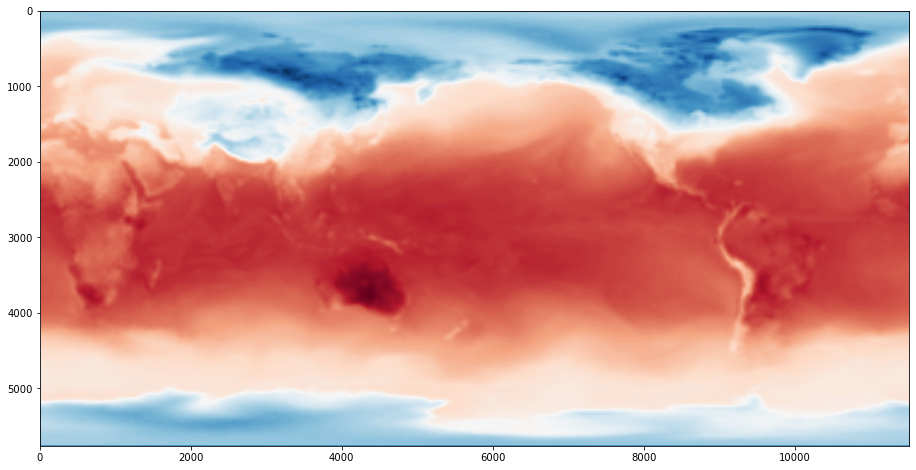

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::, ::], cmap='RdBu_r')

**Integrate with `dask.array`**

Make a list of `dask.array` objects out of your list of `h5py.Dataset` objects using the `da.from_array` function with a chunk size of `(500, 500)`.

In [53]:
weather_arrays = [da.from_array(day,chunks=(500,500)) for day in dsets]
weather_arrays[:2]

[dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500)>]

In [ ]:
# %load solutions/02-dask-arrays-make-arrays.py
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
arrays

**Stack this list of `dask.array` objects into a single `dask.array` object with `da.stack`**

Stack these along the first axis so that the shape of the resulting array is `(31, 5760, 11520)`.

In [61]:
x = da.stack(weather_arrays)
x

,Array,Chunk
Bytes,16.46 GB,2.00 MB
Shape,"(31, 5760, 11520)","(1, 500, 500)"
Count,17887 Tasks,8928 Chunks
Type,float64,numpy.ndarray


In [ ]:
# %load solutions/02-dask-arrays-stacked.py
x = da.stack(arrays, axis=0)
x

**Plot the mean of this array along the time (`0th`) axis**

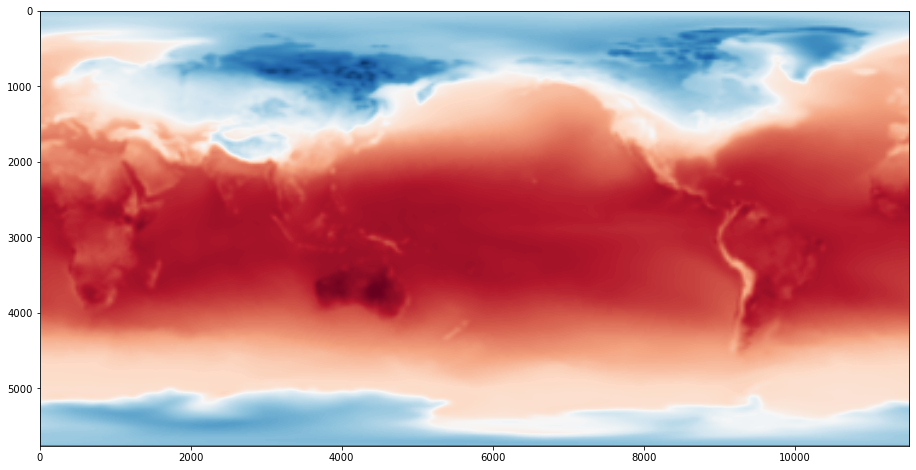

In [63]:
# complete the following
mean_over_time = x.mean(0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(mean_over_time, cmap='RdBu_r')

In [ ]:
# %load solutions/02-dask-arrays-weather-mean.py
result = x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')

**Plot the difference of the first day from the mean**

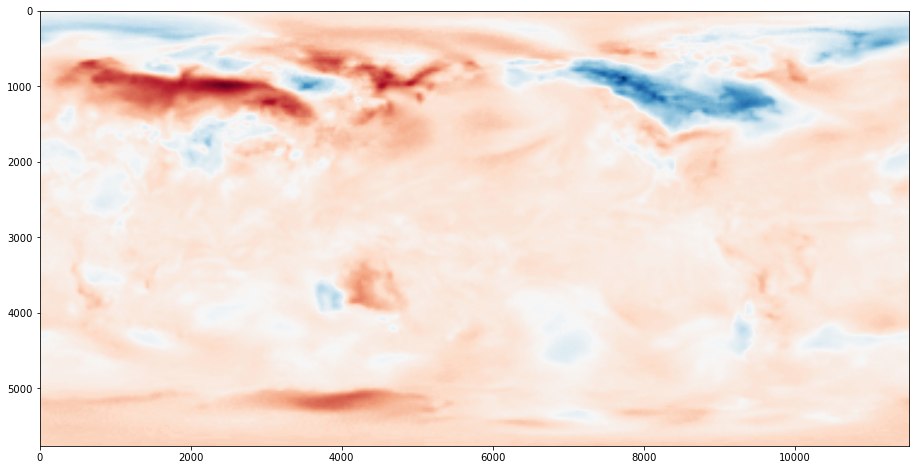

In [66]:
# complete the following
diff = x[0,:,:] - mean_over_time
fig = plt.figure(figsize=(16, 8))
plt.imshow(diff, cmap='RdBu_r')

In [ ]:
# %load solutions/02-dask-arrays-weather-difference.py
result = x[0] - x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r')

### Exercise:  Subsample and store

In the above exercise the result of our computation is small, so we can call `compute` safely.  Sometimes our result is still too large to fit into memory and we want to save it to disk.  In these cases you can use one of the following two functions

1.  `da.store`: Store dask.array into any object that supports numpy setitem syntax, e.g.

        f = h5py.File('myfile.hdf5')
        output = f.create_dataset(shape=..., dtype=...)
        
        da.store(my_dask_array, output)
        
2.  `da.to_hdf5`: A specialized function that creates and stores a `dask.array` object into an `HDF5` file.

        da.to_hdf5('data/myfile.hdf5', '/output', my_dask_array)
        
The task in this exercise is to **use numpy step slicing to subsample the full dataset by a factor of two in both the latitude and longitude direction and then store this result to disk** using one of the functions listed above.

As a reminder, Python slicing takes three elements

    start:stop:step

    >>> L = [1, 2, 3, 4, 5, 6, 7]
    >>> L[::3]
    [1, 4, 7]

In [68]:
da.to_hdf5('data/myfile.hdf5', '/output', x[:,::2,::2])

In [ ]:
# %load solutions/Array-03.py
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]

import dask.array as da
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]

x = da.stack(arrays, axis=0)

result = x[:, ::2, ::2]

da.to_hdf5(os.path.join('data', 'myfile.hdf5'), '/output', result)


## Example: Lennard-Jones potential

The [Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is used in partical simuluations in physics, chemistry and engineering. It is highly parallelizable.

First, we'll run and profile the Numpy version on 7,000 particles.

In [69]:
import numpy as np

# make a random collection of particles
def make_cluster(natoms, radius=40, seed=1981):
    np.random.seed(seed)
    cluster = np.random.normal(0, radius, (natoms,3))-0.5
    return cluster

def lj(r2):
    sr6 = (1./r2)**3
    pot = 4.*(sr6*sr6 - sr6)
    return pot

# build the matrix of distances
def distances(cluster):
    diff = cluster[:, np.newaxis, :] - cluster[np.newaxis, :, :]
    mat = (diff*diff).sum(-1)
    return mat

# the lj function is evaluated over the upper traingle
# after removing distances near zero
def potential(cluster):
    d2 = distances(cluster)
    dtri = np.triu(d2)
    energy = lj(dtri[dtri > 1e-6]).sum()
    return energy

In [70]:
cluster = make_cluster(int(7e3), radius=500)

In [71]:
%time potential(cluster)

CPU times: user 3.14 s, sys: 11.4 s, total: 14.5 s
Wall time: 14.6 s


-0.21282893668845293

Notice that the most time consuming function is `distances`.

In [74]:
# this would open in another browser tab
# %load_ext snakeviz
# %snakeviz potential(cluster)

# alternative simple version given text results in this tab
%prun -s tottime potential(cluster)

### Dask version

Here's the Dask version. Only the `potential` function needs to be rewritten to best utilize Dask.

Note that `da.nansum` has been used over the full $NxN$ distance matrix to improve parallel efficiency.


In [75]:
import dask.array as da

# compute the potential on the entire
# matrix of distances and ignore division by zero
def potential_dask(cluster):
    d2 = distances(cluster)
    energy = da.nansum(lj(d2))/2.
    return energy

Let's convert the NumPy array to a Dask array. Since the entire NumPy array fits in memory it is more computationally efficient to chunk the array by number of CPU cores.

In [76]:
from os import cpu_count

dcluster = da.from_array(cluster, chunks=cluster.shape[0]//cpu_count())

In [77]:
cpu_count()

16

This step should scale quite well with number of cores. The warnings are complaining about dividing by zero, which is why we used `da.nansum` in `potential_dask`.

In [78]:
e = potential_dask(dcluster)
%time e.compute()

/opt/conda/lib/python3.7/site-packages/dask/array/core.py:3767: PerformanceWarning: Increasing number of chunks by factor of 17
  **blockwise_kwargs
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)
/opt/conda/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in subtract
  return func(*args2)


CPU times: user 5.42 s, sys: 260 ms, total: 5.68 s
Wall time: 1.31 s


-0.2128289366884531

Limitations
-----------

Dask.array does not implement the entire numpy interface.  Users expecting this
will be disappointed.  Notably dask.array has the following failings:

1.  Dask does not implement all of ``np.linalg``.  This has been done by a
    number of excellent BLAS/LAPACK implementations and is the focus of
    numerous ongoing academic research projects.
2.  Dask.array does not support any operation where the resulting shape
    depends on the values of the array.  In order to form the Dask graph we
    must be able to infer the shape of the array before actually executing the
    operation.  This precludes operations like indexing one Dask array with
    another or operations like ``np.where``.
3.  Dask.array does not attempt operations like ``sort`` which are notoriously
    difficult to do in parallel and are of somewhat diminished value on very
    large data (you rarely actually need a full sort).
    Often we include parallel-friendly alternatives like ``topk``.
4.  Dask development is driven by immediate need, and so many lesser used
    functions, like ``np.full_like`` have not been implemented purely out of
    laziness.  These would make excellent community contributions.